# 기본 CF 알고리즘

In [106]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


def get_dataset_1() -> "pd.DataFrame":
  """users, movies, ratings dataframe을 반환하는 함수

  Returns:
      pd.DataFrame: users, movies, ratings dataframe
  """
  u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
  i_cols = ['movie_id', 'title', 'release_date', 'video release date', 'IMDB URL', 'unknown',
            'Action', 'Adventure', 'Animation', 'children\s', 'Comedy', 'Crime', 'Documentary', 'Drama',
            'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
            'Western']
  r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']

  users = pd.read_csv('../data2/u.user', sep='|', names=u_cols, encoding='latin-1')
    
  movies = pd.read_csv('../data2/u.item', sep='|', names=i_cols, encoding='latin-1')
  movies = movies[['movie_id', 'title']]
  
  ratings = pd.read_csv('../data2/u.data', sep='\t', names=r_cols, encoding='latin-1')
  ratings.drop('timestamp', axis=1, inplace=True)
  
  return users, movies, ratings

users, movies, ratings = get_dataset_1()

X = ratings.copy()
y = ratings['user_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=25)

rating_matrix = X_train.pivot(index="user_id", columns='movie_id', values='rating')

def RMSE(y_true:"pd.Series"or "np.array", y_pred:"pd.Series") -> float:
  """_summary_

  Args:
      y_true (pd.Series&quot;or&quot;np.array): y의 정답
      y_pred (pd.Series&quot;or&quot;np.array): y의 예측치

  Returns:
      float: RMSE
  """
  return np.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))

# 모델별 RMSE를 계산하는 함수
def score(model) -> float:
  """모델별 RMSE를 계산하는 함수

  Args:
      model (_type_): rating을 예측하는 모델

  Returns:
      float: RMSE
  """
  id_pairs = zip(X_test['user_id'], X_test['movie_id'])
  
  y_pred = np.array([model(user_id, movie_id) for (user_id, movie_id) in id_pairs])
  y_true = np.array(X_test['rating'])

  return RMSE(y_true, y_pred)



In [107]:
from sklearn.metrics.pairwise import cosine_similarity

matrix_dummy = rating_matrix.copy().fillna(0)

user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

In [108]:
# 이웃을 전체 사용자로 설정
def CF_simple(user_id:str, movie_id:str) -> float:
  """이웃을 전체 사용자로 설정하고, 
  주어진 영화에 대해서 평가한 각 사용자에 대해서, 평점을 유사도로 가중평균한 예측치를 구함.
  즉, 해당 user id가 movie id를 어떻게 평가할 것인지를 유사도로 평점을 가중평균해 예측하는 함수 

  Args:
      user_id (str): 사용자 id
      movie_id (str): movie id

  Returns:
      float: user id와 movie id를 평가한 사용자에 대한, 유사도로 평점을 가중평균한 예측치
  """
  # 해당 movie id에 대해서 평가한 값이 있는지 확인
  if movie_id in rating_matrix.columns:
    movie_ratings = rating_matrix[movie_id].copy()
    # movie_id에 대해서 평가하지 않은 user 
    none_rating_idx = movie_ratings[movie_ratings.isnull()].index
    movie_ratings = movie_ratings.dropna()
    
    sim_scores = user_similarity[user_id].copy()
    sim_scores = sim_scores.dropna()
    # 평가하지 않은 유저는 뺴준다.
    sim_scores = sim_scores.drop(none_rating_idx, axis=0)
    
    # 주어진 영화에 대해서 평가한 각 사용자에 대해서 평점을 유사도로 가중평균한 예측치를 구함
    mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
  # 없으면 3.0으로 예측
  else:
    mean_rating = 3.0
    
  return mean_rating

In [109]:
score(CF_simple)

1.0196376882827216

연습문제   
위의 코드를 수정해서 코사인 유사도 대신에 피어슨 상관계수를 사용하는 코드를 작성하고 RMSE를 계산하세요.

In [110]:
from sklearn.metrics.pairwise import cosine_similarity

matrix_dummy = rating_matrix.copy().fillna(0)

user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

user_corr = matrix_dummy.T.corr()
user_corr = pd.DataFrame(user_corr, index=rating_matrix.index, columns=rating_matrix.index)

def CF_simple_using(simil:str):
  """similarity를 어떻게 계산할지 여부에 따라 해당 model을 return하는 함수

  Args:
      simil (str): similarity계산 방식 ( cosine or corr )

  Raises:
      Exception: simil값이 정확하지 않을 때

  Returns:
      _type_: CF_simple model
  """
  if simil == 'cosine':
    return CF_simple_cosine
  elif simil == 'corr':
    return CF_simple_corr
  else:
    raise Exception('simil값을 확인해주세요 (cosine or corr)')    

# 이웃을 전체 사용자로 설정
def CF_simple_cosine(user_id:str, movie_id:str) -> float:
  """이웃을 전체 사용자로 설정하고, 
  주어진 영화에 대해서 평가한 각 사용자에 대해서, 평점을 유사도로 가중평균한 예측치를 구함.
  즉, 해당 user id가 movie id를 어떻게 평가할 것인지를 유사도로 평점을 가중평균해 예측하는 함수 
  유사도 : cosine similarity
  Args:
      user_id (str): 사용자 id
      movie_id (str): 영화 id
  Returns:
      float: user id와 movie id를 평가한 사용자에 대한, 유사도로 평점을 가중평균한 예측치
  """
  # 해당 movie id에 대해서 평가한 값이 있는지 확인
  if movie_id in rating_matrix.columns:
    movie_ratings = rating_matrix[movie_id].copy()
    # movie_id에 대해서 평가하지 않은 user 
    none_rating_idx = movie_ratings[movie_ratings.isnull()].index
    movie_ratings = movie_ratings.dropna()
    
    sim_scores = user_similarity[user_id].copy()
    sim_scores = sim_scores.dropna()
    # 평가하지 않은 유저는 뺴준다.
    sim_scores = sim_scores.drop(none_rating_idx, axis=0)
    
    # 주어진 영화에 대해서 평가한 각 사용자에 대해서 평점을 유사도로 가중평균한 예측치를 구함
    mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
  # 없으면 3.0으로 예측
  else:
    mean_rating = 3.0
    
  return mean_rating

# 이웃을 전체 사용자로 설정
def CF_simple_corr(user_id:str, movie_id:str) -> float:
  """이웃을 전체 사용자로 설정하고, 
  주어진 영화에 대해서 평가한 각 사용자에 대해서, 평점을 유사도로 가중평균한 예측치를 구함.  
  즉, 해당 user id가 movie id를 어떻게 평가할 것인지를 유사도로 평점을 가중평균해 예측하는 함수.
  유사도: correlation
  
  Args:
      user_id (str): 사용자 id
      movie_id (str): 영화 id
  Returns:
      float: user id와 movie id를 평가한 사용자에 대한, 유사도로 평점을 가중평균한 예측치
  """
  # 해당 movie id에 대해서 평가한 값이 있는지 확인
  if movie_id in rating_matrix.columns:
    movie_ratings = rating_matrix[movie_id].copy()
    # movie_id에 대해서 평가하지 않은 user 
    none_rating_idx = movie_ratings[movie_ratings.isnull()].index
    movie_ratings = movie_ratings.dropna()
    
    sim_scores = user_corr[user_id].copy()
    sim_scores = sim_scores.dropna()
    # 평가하지 않은 유저는 뺴준다.
    sim_scores = sim_scores.drop(none_rating_idx, axis=0)
    
    # 주어진 영화에 대해서 평가한 각 사용자에 대해서 평점을 유사도로 가중평균한 예측치를 구함
    mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
  # 없으면 3.0으로 예측
  else:
    mean_rating = 3.0
    
  return mean_rating

In [111]:
print(f"smilarity: cosine , {score(CF_simple_using(simil='cosine')):.4f}")
print(f"smilarity: corr , {score(CF_simple_using(simil='corr')):.4f}")

smilarity: cosine , 1.0196
smilarity: corr , 1.1566


# 이웃을 고려한 CF

In [112]:
# 모델별 RMSE를 계산하는 함수
def score_CF(model, simil:str='cosine', neighbor_size:int=0) -> float:
  """CF 모델별 RMSE를 계산하는 함수

  Args:
      model (_type_): rating을 예측하는 CF 모델 \n
      simil (str): similarity계산 방식 ( cosine or corr )\n
      neighbor_size (int): 이웃의 수 \n
  Raises:
      Exception: simil값이 정확하지 않을 때
  Returns:
      float: RMSE
  """
  if not(simil == 'cosine' or simil == 'corr'):
    raise Exception('simil값을 확인해주세요 (cosine or corr)')   
  
  id_pairs = zip(X_test['user_id'], X_test['movie_id'])
  
  y_pred = np.array([model(user_id, movie_id, simil, neighbor_size) for (user_id, movie_id) in id_pairs])
  y_true = np.array(X_test['rating'])

  return RMSE(y_true, y_pred)

In [116]:
# 이웃을 전체 사용자로 설정
def CF_knn(user_id:str, movie_id:str, simil: str, neighbor_size: int) -> float:
  """이웃을 전체 사용자로 설정하고, 
  주어진 영화에 대해서 평가한 각 사용자에 대해서, 평점을 유사도로 가중평균한 예측치를 구함.\n
  즉, 해당 user id가 movie id를 어떻게 평가할 것인지를 유사도로 평점을 가중평균해 예측하는 함수. \n
  유사도: correlation or cosine \n
  유사도 기준 상위 neighbor_size(k)만큼을 이웃으로 정의. 이웃에 대해서만 가중평균을 진행.\n
  
  Args:
      user_id (str): 사용자 id \n
      movie_id (str): 영화 id \n
      simil (str): similarity계산 방식 ( cosine or corr ) \n
      neighbor_size (int): 이웃의 수 \n
  Returns:
      float: user id와 movie id를 평가한 사용자에 대한, 유사도로 평점을 가중평균한 예측치
  """
  if simil == 'cosine':
    similarity = user_similarity
  else:
    similarity = user_corr
  
  # 해당 movie id에 대해서 평가한 값이 있는지 확인 ( train set에 movie id가 있는지 확인 )
  if movie_id in rating_matrix.columns:
    movie_ratings = rating_matrix[movie_id].copy()
    # movie_id에 대해서 평가하지 않은 user 
    none_rating_idx = movie_ratings[movie_ratings.isnull()].index
    movie_ratings = movie_ratings.dropna()
    
    sim_scores = similarity[user_id].copy()
    sim_scores = sim_scores.dropna()
    # 평가하지 않은 유저는 뺴준다.
    sim_scores = sim_scores.drop(none_rating_idx, axis=0)
    sim_scores.sort_values(ascending=False, inplace=True)
    # 유사도 개수가 0일 때 
    if len(sim_scores) == 0:
      mean_rating = 3.0
      return mean_rating
    
    # 주어진 영화에 대해서 평가한 각 사용자에 대해서 평점을 유사도로 가중평균한 예측치를 구함
    # k가 0인경우 ( 안주어진 경우 )
    if neighbor_size == 0:
      mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
    # K가 주어진 경우
    else: 
      neighbor_size = min(neighbor_size, len(sim_scores))
      
      sim_scores = sim_scores[:neighbor_size]      
      movie_ratings = movie_ratings[sim_scores.index][:neighbor_size]
        
      mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
  # 없으면 3.0으로 예측
  else:
    mean_rating = 3.0
    
  return mean_rating

In [133]:
score_CF(CF_knn, simil='cosine', neighbor_size=30)

0.9022245790355954

In [129]:
# 전체 데이터셋에 대해서 추천
from sklearn.metrics.pairwise import cosine_similarity

rating_matrix = ratings.pivot_table(values='rating', index='user_id', columns='movie_id')
matrix_dummy = rating_matrix.copy().fillna(0)

user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

def recommender_CF(user_id:str, n_items:int=10, neighbor_size:int=20) -> "pd.DataFrame":
  """user id에 대해서 비슷한 이웃 (cosine 유사도 기반 상위 neighbor_size만큼) 과의 유사도와 \n
  평점을 가중평균한 가중평균을 기반으로 , 상위 n_items 개수만큼 추출하여 추천해주는 함수.

  Args:
      user_id (str): 추천받고자 하는 사용자 id \n
      n_items (int, optional): 추천받고 싶은 movie의 개수. Defaults to 10. \n
      neighbor_size (int, optional): 가중평균 구할 때 사용할 이웃의 숫자. Defaults to 20. \n

  Returns:
      pd.Series: 추천하는 영화 dataframe
  """
  predictions = []

  user_rating = matrix_dummy.loc[user_id]
  # 평가하지 않은 영화에 대해서 추리기
  items = user_rating[user_rating == 0]
  # 앞서 구현한 CF_knn을 이용해 유사도 기반 가중평균값 구하기
  for item in items.index:
    predictions.append(CF_knn(user_id, item, simil='cosine', neighbor_size=neighbor_size))
  # 가중평균을 기준으로 정렬. 상위 n_items개수만큼 추출.
  recommendations = pd.Series(data=predictions, index=items.index, dtype=float)
  recommendations = recommendations.sort_values(ascending=False)[:n_items]
  # 상위 movies들에 대해 제목과 예측점수 return.
  recommended_items = pd.DataFrame()
  recommended_items['title'] = movies.loc[recommendations.index]['title']
  recommended_items['predicted rating'] =  recommendations.values
  
  return recommended_items

In [130]:
recommender_CF(user_id=2, n_items=5, neighbor_size=30)

,title,predicted rating
movie_id,,
1653,Chairman of the Board (1998),5.0
1536,Cosi (1996),5.0
1122,"Last Time I Saw Paris, The (1954)",5.0
1189,That Old Feeling (1997),5.0
814,One Fine Day (1996),5.0


# 최적의 이웃 크기 결정   

In [ ]:
# train set에 대해서 측정
# CF_knn 보완해야되는 부분. 따로 user_similarity, user_corr 할당해주고 써야되는 문제.
X = ratings.copy();y = ratings['user_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=25)
rating_matrix = X_train.pivot(index="user_id", columns='movie_id', values='rating')
matrix_dummy = rating_matrix.copy().fillna(0)

user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

user_corr = matrix_dummy.T.corr()
user_corr = pd.DataFrame(user_corr, index=rating_matrix.index, columns=rating_matrix.index)

In [148]:
neighbor_sizes = [i for i in range(10, 61)]
results = []

for k in neighbor_sizes:
  result = score_CF(CF_knn, simil='cosine', neighbor_size=k)
  results.append(result)
  if (k % 10 == 0):
    print(f"neighbor_size : {k} / RMSE : {result:.4f}")

neighbor_size : 10 / RMSE : 1.0332
neighbor_size : 20 / RMSE : 1.0164
neighbor_size : 30 / RMSE : 1.0142
neighbor_size : 40 / RMSE : 1.0141
neighbor_size : 50 / RMSE : 1.0140
neighbor_size : 60 / RMSE : 1.0144


Text(0, 0.5, 'RMSE')

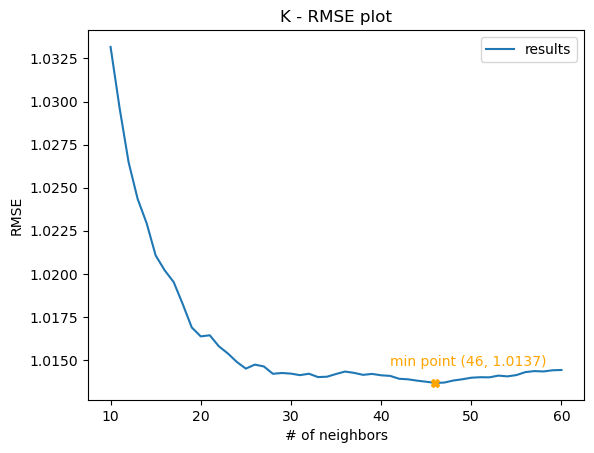

In [180]:
import matplotlib.pyplot as plt

result_df = pd.DataFrame(index=neighbor_sizes, data=results, columns=['results'])
result_df.plot()

min_k =result_df.index[np.argmin(result_df['results'])]
min_rmse = result_df.loc[min_k]['results']

plt.text(min_k-5, min_rmse+0.001, f'min point ({min_k}, {min_rmse:.4f})', color='orange')
plt.plot(min_k, min_rmse, marker='X', color='orange')

plt.title('K - RMSE plot')
plt.xlabel('# of neighbors')
plt.ylabel('RMSE')

40~50 사이에서 최적의 K값을 가질 것이라 판단됨. 

In [182]:
# 여기서 구한 k값으로 다시 추천 받아보기
recommender_CF(user_id=2, n_items=30, neighbor_size=46)

,title,predicted rating
movie_id,,
1599,Guantanamera (1994),5.000000
1189,That Old Feeling (1997),5.000000
1500,Prisoner of the Mountains (Kavkazsky Plennik) ...,5.000000
1448,Pather Panchali (1955),5.000000
1122,"Last Time I Saw Paris, The (1954)",5.000000
1653,Chairman of the Board (1998),5.000000
1175,Welcome To Sarajevo (1997),5.000000
1656,Target (1995),5.000000
1293,Ayn Rand: A Sense of Life (1997),5.000000


13번째 영화까지는 모두 5.0이므로, 상위 5개만 뽑았다면 나머지 8개는 우연히 추천이 안되는 문제가 발생한다.

# 사용자의 평가경향을 고려한 CF

$p_{a, i} = \overline r_a + \frac
{\sum_{u=1}^nw_{a,u}(r_{u,i} - \overline r_u)}
{\sum_{u=1}^nw_{a,u}}$

In [189]:
# 이웃을 전체 사용자로 설정
def CF_knn_bias(user_id:str, movie_id:str, simil: str, neighbor_size: int) -> float:
  """
  주어진 영화에 대해서 평가한 사용자에 대해서, 평점을 기반으로 유사도를 계산하고, 유사도와 평점을 가중평균해 예측치를 구함.\n
  유사도 기준 상위 neighbor_size(=k)만큼을 이웃으로 정의. 이웃에 대해서만 가중평균을 진행.\n
  사용자의 평가경향을 고려 \n
  
  Args:
      user_id (str): 사용자 id \n
      movie_id (str): 영화 id \n
      simil (str): similarity계산 방식 ( cosine or corr ) \n
      neighbor_size (int): 이웃의 수 \n
  Returns:
      float: user id와 movie id를 평가한 사용자에 대한, 유사도로 평점을 가중평균한 예측치
  """
  
  # 구할 수 없는 경우에는 평균평점으로 대체한다.
  default_rating = rating_mean[user_id]
  
  # 유사도 기준 설정. 
  if simil == 'cosine':
    similarity = user_similarity
  else:
    similarity = user_corr
  
  # 해당 movie id에 대해서 평가한 값이 있는지 확인 ( train set에 movie id가 있는지 확인 )
  if movie_id in rating_matrix.columns:
    movie_ratings = rating_bias[movie_id].copy() #  rating_bias를 이용해 평가경향 제거해줌.
    # movie_id에 대해서 평가하지 않은 user 
    none_rating_idx = movie_ratings[movie_ratings.isnull()].index
    movie_ratings = movie_ratings.dropna()
    
    sim_scores = similarity[user_id].copy()
    sim_scores = sim_scores.dropna()
    # 평가하지 않은 유저는 뺴준다.
    sim_scores = sim_scores.drop(none_rating_idx, axis=0)
    # 유사도 개수가 0일 때 
    if len(sim_scores) == 0:
      return default_rating
    
    # 주어진 영화에 대해서 평가한 각 사용자에 대해서 평점을 유사도로 가중평균한 예측치를 구함
    # k가 0인경우 ( 안주어진 경우 )
    if neighbor_size == 0:
      mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
    # K가 주어진 경우
    else:
      sim_scores = sim_scores.sort_values(ascending=False)
 
      neighbor_size = min(neighbor_size, len(sim_scores))
      
      sim_scores = sim_scores[:neighbor_size]      
      movie_ratings = movie_ratings[sim_scores.index][:neighbor_size]
      
      # 사용자의 평가경향 더 해줌
      mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum() + default_rating
  # 없으면 3.0으로 예측
  else:
    mean_rating = default_rating
    
  return mean_rating

In [191]:
# train set에 대해서 측정
# CF_knn 보완해야되는 부분. 따로 user_similarity, user_corr 할당해주고 써야되는 문제.
X = ratings.copy();y = ratings['user_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=25)
rating_matrix = X_train.pivot(index="user_id", columns='movie_id', values='rating')
matrix_dummy = rating_matrix.copy().fillna(0)

user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

user_corr = matrix_dummy.T.corr()
user_corr = pd.DataFrame(user_corr, index=rating_matrix.index, columns=rating_matrix.index)

rating_mean = rating_matrix.mean(axis=1)
rating_bias = (rating_matrix.T - rating_mean).T # 평가경향 제거

print(f"model: basic model / rmse: {score_CF(CF_knn, simil='cosine', neighbor_size=30)}")
print(f"model: bias reducing model / rmse: {score_CF(CF_knn_bias, simil='cosine', neighbor_size=30)}")

model: basic model / rmse: 1.0142086411731543
model: bias reducing model / rmse: 0.9441684573734636


연습문제  
편향이 제거된 모델을 이용해 사용자 ID를 지정하면 해당 사용자를 위해 5개의 영화를 추천. 위의 결과와 비교.  

In [196]:
# 전체 데이터셋에 대해서 추천
from sklearn.metrics.pairwise import cosine_similarity

rating_matrix = ratings.pivot_table(values='rating', index='user_id', columns='movie_id')
matrix_dummy = rating_matrix.copy().fillna(0)

user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

rating_mean = rating_matrix.mean(axis=1)
rating_bias = (rating_matrix.T - rating_mean).T # 평가경향 제거

def recommender_CF_bias(user_id:str, n_items:int=10, neighbor_size:int=20) -> "pd.DataFrame":
  """user id에 대해서 비슷한 이웃 (cosine 유사도 기반 상위 neighbor_size만큼) 과의 유사도와 \n
  평점을 가중평균한 가중평균을 기반으로 , 상위 n_items 개수만큼 추출하여 추천해주는 함수.

  Args:
      user_id (str): 추천받고자 하는 사용자 id \n
      n_items (int, optional): 추천받고 싶은 movie의 개수. Defaults to 10. \n
      neighbor_size (int, optional): 가중평균 구할 때 사용할 이웃의 숫자. Defaults to 20. \n

  Returns:
      pd.Series: 추천하는 영화 dataframe
  """
  predictions = []

  user_rating = matrix_dummy.loc[user_id]
  # 평가하지 않은 영화에 대해서 추리기
  items = user_rating[user_rating == 0]
  # 앞서 구현한 CF_knn을 이용해 유사도 기반 가중평균값 구하기
  for item in items.index:
    predictions.append(CF_knn_bias(user_id, item, simil='cosine', neighbor_size=neighbor_size))
  # 가중평균을 기준으로 정렬. 상위 n_items개수만큼 추출.
  recommendations = pd.Series(data=predictions, index=items.index, dtype=float)
  recommendations = recommendations.sort_values(ascending=False)[:n_items]
  # 상위 movies들에 대해 제목과 예측점수 return.
  recommended_items = pd.DataFrame()
  recommended_items['title'] = movies.loc[recommendations.index]['title']
  recommended_items['predicted rating'] =  recommendations.values
  
  return recommended_items

In [198]:
recommender_CF_bias(2, n_items=5, neighbor_size=46)

,title,predicted rating
movie_id,,
814,One Fine Day (1996),5.612193
1536,Cosi (1996),5.414304
1467,"Cure, The (1995)",5.172151
1500,Prisoner of the Mountains (Kavkazsky Plennik) ...,5.132155
1599,Guantanamera (1994),5.127928


그 외의 CF 정확도 개선방법

In [207]:
rating_binary = np.array((rating_matrix > 0).astype(float))
counts = np.dot(rating_binary, rating_binary.T)
counts = pd.DataFrame(counts, index=rating_matrix.index, columns=rating_matrix.index).fillna(0)
# 공통으로 평가한 영화의 수 
counts 

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,272.0,18.0,8.0,7.0,80.0,96.0,145.0,34.0,5.0,77.0,...,77.0,15.0,48.0,19.0,36.0,15.0,52.0,10.0,27.0,83.0
2,18.0,62.0,9.0,7.0,5.0,32.0,18.0,6.0,6.0,16.0,...,15.0,14.0,33.0,20.0,24.0,11.0,17.0,7.0,12.0,9.0
3,8.0,9.0,54.0,13.0,1.0,10.0,14.0,7.0,2.0,8.0,...,3.0,2.0,16.0,6.0,10.0,2.0,15.0,4.0,9.0,2.0
4,7.0,7.0,13.0,24.0,2.0,6.0,12.0,8.0,2.0,4.0,...,3.0,1.0,8.0,6.0,7.0,1.0,10.0,4.0,8.0,4.0
5,80.0,5.0,1.0,2.0,175.0,42.0,102.0,23.0,4.0,35.0,...,58.0,6.0,15.0,5.0,21.0,7.0,28.0,6.0,17.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,15.0,11.0,2.0,1.0,7.0,14.0,16.0,4.0,1.0,6.0,...,7.0,18.0,23.0,10.0,29.0,49.0,5.0,6.0,3.0,12.0
940,52.0,17.0,15.0,10.0,28.0,54.0,68.0,18.0,6.0,51.0,...,45.0,7.0,26.0,13.0,18.0,5.0,107.0,7.0,23.0,28.0
941,10.0,7.0,4.0,4.0,6.0,11.0,7.0,7.0,3.0,6.0,...,3.0,6.0,16.0,7.0,14.0,6.0,7.0,22.0,4.0,5.0


In [216]:
# 이웃을 전체 사용자로 설정
def CF_knn_bias_sig(user_id:str, movie_id:str, simil: str, neighbor_size: int) -> float:
  """
  주어진 영화에 대해서 평가한 사용자에 대해서, 평점을 기반으로 유사도를 계산하고, 
  유사도와 평점을 가중평균해 예측치를 구함.\n
  유사도 기준 상위 neighbor_size(=k)만큼을 이웃으로 정의. 이웃에 대해서만 가중평균을 진행.\n
  사용자의 평가경향을 고려 \n
  신뢰도(공통으로 평가한 아이템의 개수)가 특정값이상(전역변수로 정의)인 유저만 이웃으로 사용. \n
  
  Args:
      user_id (str): 사용자 id \n
      movie_id (str): 영화 id \n
      simil (str): similarity계산 방식 ( cosine or corr ) \n
      neighbor_size (int): 이웃의 수 \n
  Returns:
      float: user id와 movie id를 평가한 사용자에 대한, 유사도로 평점을 가중평균한 예측치
  """
  
  # 구할 수 없는 경우에는 평균평점으로 대체한다.
  default_rating = rating_mean[user_id]
  
  # 유사도 기준 설정. 
  if simil == 'cosine':
    similarity = user_similarity
  else:
    similarity = user_corr
  
  # 해당 movie id에 대해서 평가한 값이 있는지 확인 ( train set에 movie id가 있는지 확인 )
  if movie_id in rating_matrix.columns:
    movie_ratings = rating_bias[movie_id].copy() #  rating_bias를 이용해 평가경향 제거해줌.
    
    common_counts = counts[user_id] # 공통으로 평가한 영화의 수
    low_significance = common_counts < SIG_LEVEL # 공통으로 평가한 영화의 수 < SIG_LVEL
    no_rating = movie_ratings.isnull() # movie_id에 대해서 평가하지 않은 user 
    none_rating_idx = movie_ratings[no_rating | low_significance].index # 평가한 영화가 없거나, 신뢰도가 낮은 user id.
    movie_ratings = movie_ratings.dropna()
    
    sim_scores = similarity[user_id].copy()
    sim_scores = sim_scores.dropna()
    # 평가하지 않은 유저 + 신뢰도가 SIG_LEVEL보다 작은 유저 뺴주기
    sim_scores = sim_scores.drop(none_rating_idx, axis=0)
    
    # 유사도 개수가 MIN_RATINGS보다 작으면 평균값으로 예측
    if len(sim_scores) < MIN_RATINGS:
      return default_rating
    
    # 주어진 영화에 대해서 평가한 각 사용자에 대해서 평점을 유사도로 가중평균한 예측치를 구함
    # k가 0인경우 ( 안주어진 경우 )
    if neighbor_size == 0:
      mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
    # K가 주어진 경우
    else:
      sim_scores = sim_scores.sort_values(ascending=False)
 
      neighbor_size = min(neighbor_size, len(sim_scores))
      
      sim_scores = sim_scores[:neighbor_size]      
      movie_ratings = movie_ratings[sim_scores.index][:neighbor_size]
      
      # 사용자의 평가경향 더 해줌
      mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum() + default_rating
  # 없으면 3.0으로 예측
  else:
    mean_rating = default_rating
    
  return mean_rating

In [212]:
# train set에 대해서 측정
# CF_knn 보완해야되는 부분. 따로 user_similarity, user_corr 할당해주고 써야되는 문제.
X = ratings.copy();y = ratings['user_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=25)
rating_matrix = X_train.pivot(index="user_id", columns='movie_id', values='rating')
matrix_dummy = rating_matrix.copy().fillna(0)

user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

user_corr = matrix_dummy.T.corr()
user_corr = pd.DataFrame(user_corr, index=rating_matrix.index, columns=rating_matrix.index)

rating_mean = rating_matrix.mean(axis=1)
rating_bias = (rating_matrix.T - rating_mean).T # 평가경향 제거

rating_binary = np.array((rating_matrix > 0).astype(float))
counts = np.dot(rating_binary, rating_binary.T)
counts = pd.DataFrame(counts, index=rating_matrix.index, columns=rating_matrix.index).fillna(0)
counts # 공통으로 평가한 영화의 수 

SIG_LEVEL = 3 # 최소 신뢰도
MIN_RATINGS = 2 # 최소 유사도 개수

print(f"model: basic model / rmse: {score_CF(CF_knn, simil='cosine', neighbor_size=30)}")
print(f"model: bias reducing model / rmse: {score_CF(CF_knn_bias, simil='cosine', neighbor_size=30)}")
print(f"model: bias reducing + sig model / rmse: {score_CF(CF_knn_bias_sig, simil='cosine', neighbor_size=30)}")


model: basic model / rmse: 1.0142086411731543
model: bias reducing model / rmse: 0.9441684573734636
model: bias reducing + sig model / rmse: 0.9433936802841534


연습문제   
결과 수정해주기 (1보다 작은건 1로, 5보다 큰 건 5로 예측하기)

In [214]:
def check_result(result:float) -> float:
  """rating의 값은 1~5사이의 값을 가지므로, 1이하면 1로, 5이상이면 5로 값을 바꿔주기

  Args:
      result (float): 모델의 결과값. 가중평균. 예측치.

  Returns:
      float: 수정된 결과값.
  """
  if (result < 1): return 1
  if (result > 5): return 5
  return result


# 이웃을 전체 사용자로 설정
def CF_knn_bias_sig_check(user_id:str, movie_id:str, simil: str, neighbor_size: int) -> float:
  """
  주어진 영화에 대해서 평가한 사용자에 대해서, 평점을 기반으로 유사도를 계산하고, 
  유사도와 평점을 가중평균해 예측치를 구함.\n
  유사도 기준 상위 neighbor_size(=k)만큼을 이웃으로 정의. 이웃에 대해서만 가중평균을 진행.\n
  사용자의 평가경향을 고려 \n
  신뢰도(공통으로 평가한 아이템의 개수)가 특정값이상(전역변수로 정의)인 유저만 이웃으로 사용. \n
  조건을 거쳐 나온 유사도의 개수가 특정값(전역변수로 정의)이하면 평균값으로 예측 \n
  결과값이 1이하면 1, 5이상이면 5로 바꿔줌 \n
  
  Args:
      user_id (str): 사용자 id \n
      movie_id (str): 영화 id \n
      simil (str): similarity계산 방식 ( cosine or corr ) \n
      neighbor_size (int): 이웃의 수 \n
  Returns:
      float: user id와 movie id를 평가한 사용자에 대한, 유사도로 평점을 가중평균한 예측치
  """
  
  # 구할 수 없는 경우에는 평균평점으로 대체한다.
  default_rating = rating_mean[user_id]
  
  # 유사도 기준 설정. 
  if simil == 'cosine':
    similarity = user_similarity
  else:
    similarity = user_corr
  
  # 해당 movie id에 대해서 평가한 값이 있는지 확인 ( train set에 movie id가 있는지 확인 )
  if movie_id in rating_matrix.columns:
    movie_ratings = rating_bias[movie_id].copy() #  rating_bias를 이용해 평가경향 제거해줌.
    
    common_counts = counts[user_id] # 공통으로 평가한 영화의 수
    low_significance = common_counts < SIG_LEVEL # 공통으로 평가한 영화의 수 < SIG_LVEL
    no_rating = movie_ratings.isnull() # movie_id에 대해서 평가하지 않은 user 
    none_rating_idx = movie_ratings[no_rating | low_significance].index # 평가한 영화가 없거나, 신뢰도가 낮은 user id.
    movie_ratings = movie_ratings.dropna()
    
    sim_scores = similarity[user_id].copy()
    sim_scores = sim_scores.dropna()
    # 평가하지 않은 유저 + 신뢰도가 SIG_LEVEL보다 작은 유저 뺴주기
    sim_scores = sim_scores.drop(none_rating_idx, axis=0)
    
    # 유사도 개수가 MIN_RATINGS보다 작으면 평균값으로 예측
    if len(sim_scores) < MIN_RATINGS:
      return default_rating
    
    # 주어진 영화에 대해서 평가한 각 사용자에 대해서 평점을 유사도로 가중평균한 예측치를 구함
    # k가 0인경우 ( 안주어진 경우 )
    if neighbor_size == 0:
      mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
    # K가 주어진 경우
    else:
      sim_scores = sim_scores.sort_values(ascending=False)
 
      neighbor_size = min(neighbor_size, len(sim_scores))
      
      sim_scores = sim_scores[:neighbor_size]      
      movie_ratings = movie_ratings[sim_scores.index][:neighbor_size]
      
      # 사용자의 평가경향 더 해줌
      mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum() + default_rating
  # 없으면 3.0으로 예측
  else:
    mean_rating = default_rating
    
  return check_result(mean_rating)

In [217]:
# train set에 대해서 측정
# CF_knn 보완해야되는 부분. 따로 user_similarity, user_corr 할당해주고 써야되는 문제.
X = ratings.copy();y = ratings['user_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=25)
rating_matrix = X_train.pivot(index="user_id", columns='movie_id', values='rating')
matrix_dummy = rating_matrix.copy().fillna(0)

user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

user_corr = matrix_dummy.T.corr()
user_corr = pd.DataFrame(user_corr, index=rating_matrix.index, columns=rating_matrix.index)

rating_mean = rating_matrix.mean(axis=1)
rating_bias = (rating_matrix.T - rating_mean).T # 평가경향 제거

rating_binary = np.array((rating_matrix > 0).astype(float))
counts = np.dot(rating_binary, rating_binary.T)
counts = pd.DataFrame(counts, index=rating_matrix.index, columns=rating_matrix.index).fillna(0)
counts # 공통으로 평가한 영화의 수 

SIG_LEVEL = 3 # 최소 신뢰도
MIN_RATINGS = 2 # 최소 유사도 개수

print(f"model: basic model / rmse: {score_CF(CF_knn, simil='cosine', neighbor_size=30)}")
print(f"model: bias reducing model / rmse: {score_CF(CF_knn_bias, simil='cosine', neighbor_size=30)}")
print(f"model: bias reducing + sig + min_rating model / rmse: {score_CF(CF_knn_bias_sig, simil='cosine', neighbor_size=30)}")
print(f"model: bias reducing + sig + min_rating + check model / rmse: {score_CF(CF_knn_bias_sig_check, simil='cosine', neighbor_size=30)}")


model: basic model / rmse: 1.0142086411731543
model: bias reducing model / rmse: 0.9441684573734636
model: bias reducing + sig + min_rating model / rmse: 0.9433936802841534
model: bias reducing + sig + min_rating + check model / rmse: 0.9419892244765159


# UBCF vs IBCF  

In [218]:
from sklearn.metrics.pairwise import cosine_similarity

X = ratings.copy();y = ratings['user_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=25)
rating_matrix = X_train.pivot(index="user_id", columns='movie_id', values='rating')

rating_matrix_t = np.transpose(rating_matrix)
matrix_dummy = rating_matrix_t.copy().fillna(0)

item_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
item_similarity = pd.DataFrame(item_similarity, index=rating_matrix_t.index, columns=rating_matrix_t.index)

In [ ]:
def CF_IBCF(user_id:str, movie_id:str):
  if movie_id in item_similarity.index:
    user_rating = rating_matrix_t[user_id]
    none_rating_idx = user_rating[user_rating.isnull()].index # 유저가 평가하지 않은 영화 
    user_rating = user_rating.dropna()
    
    sim_scores = item_similarity[movie_id]
    sim_scores = sim_scores.drop(none_rating_idx, axis=0)
    mean_rating = np.dot(sim_scores, user_rating) / sim_scores.sum()
  else:
    mean_rating = 3.0
  
  return mean_rating
    
    
    
    
    
    

In [225]:
10 in item_similarity

True